In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import tqdm
import torchvision
import matplotlib.pyplot as plt

# Classical ML Classification Example

In [2]:
# Load Images and resize all to a standard size

standard_shape = (300, 300)

ac_images = []
for f in os.listdir("animal_crossing"):
    path = os.path.join("animal_crossing", f)
    img = Image.open(path).resize(standard_shape)
    img = np.array(img.convert('RGB'))
    ac_images.append(img.flatten())
ac_images = np.array(ac_images)

dm_images = []
for f in os.listdir("doom"):
    path = os.path.join("doom", f)
    img = Image.open(path).resize(standard_shape)
    img = np.array(img.convert('RGB'))
    dm_images.append(img.flatten())
dm_images = np.array(dm_images)

In [3]:
# Create Labels

ac_labels = np.zeros(ac_images.shape[0])
dm_labels = np.ones(dm_images.shape[0])


# Combine and Shuffle

shuffled_ids = np.arange(ac_labels.shape[0] + dm_labels.shape[0])
np.random.shuffle(shuffled_ids)
all_images = np.concatenate((ac_images, dm_images), axis=0)[shuffled_ids]
all_labels = np.concatenate((ac_labels, dm_labels), axis=0)[shuffled_ids]

# Split into Training and Testing

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3)

# Standardize Data

scaler = StandardScaler()
scale_x_train = scaler.fit_transform(X_train)
scale_x_test = scaler.transform(X_test)

print(ac_images.shape)
print(dm_images.shape)
print(all_images.shape)
print(all_labels.shape)


(757, 270000)
(840, 270000)
(1597, 270000)
(1597,)


In [4]:
# Perform PCA on training set

pca = PCA()
pca.fit(scale_x_train)
print(pca.components_.shape)

(1117, 270000)


Text(0, 0.5, 'Cumulative Energy')

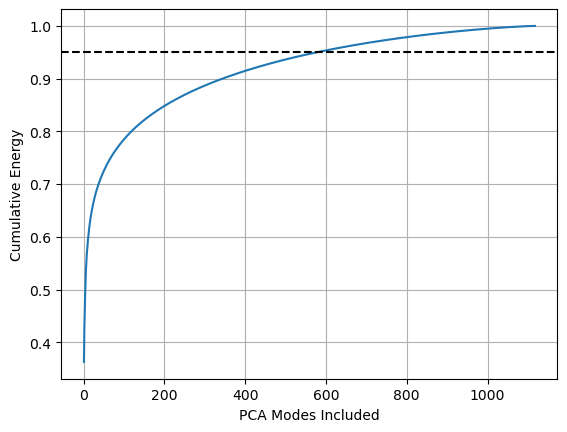

In [5]:
# Cumulative Energy
svs = pca.singular_values_
cum_e = np.cumsum(np.power(svs,2)/np.sum(np.power(svs,2)))
plt.plot(np.arange(1, len(svs) + 1), cum_e)
plt.axhline(y=0.95, color="k", linestyle="--")
plt.grid(True)
plt.xlabel('PCA Modes Included')
plt.ylabel('Cumulative Energy')

In [6]:
# Modes needed to capture 95% of the variance
k95 = next(i for i, v in enumerate(cum_e) if v > 0.95) + 1
print("Modes needed to to capture 95%: {}".format(k95))
pcak95 = PCA(n_components=k95)
pcak95.fit(scale_x_train)
red_x_train = pcak95.components_ @ scale_x_train.T
red_x_test = pcak95.components_ @ scale_x_test.T

Modes needed to to capture 95%: 578


In [7]:
print(red_x_train.shape)

(578, 1117)


In [8]:
cv_scores = []
cv_stds = []
te_scores = []
tr_scores = []

In [9]:
# Ridge Classifier
ridge = RidgeClassifierCV()
ridge.fit(red_x_train.T, y_train)
testing_score = ridge.score(red_x_test.T, y_test)
training_score = ridge.score(red_x_train.T, y_train)
print("Training Score: {}".format(training_score))
print("Testing Score: {}".format(testing_score))

scores = cross_val_score(ridge, red_x_train.T, y_train, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
te_scores.append(testing_score)
tr_scores.append(training_score)

Training Score: 0.918531781557744
Testing Score: 0.68125


In [10]:
# Train LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(red_x_train.T, y_train)
testing_score = lda.score(red_x_test.T, y_test)
training_score = lda.score(red_x_train.T, y_train)
print("Training Score: {}".format(training_score))
print("Testing Score: {}".format(testing_score))

scores = cross_val_score(lda, red_x_train.T, y_train, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
te_scores.append(testing_score)
tr_scores.append(training_score)

Training Score: 0.918531781557744
Testing Score: 0.68125


In [11]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(red_x_train.T, y_train)
testing_score = knn.score(red_x_test.T, y_test)
training_score = knn.score(red_x_train.T, y_train)
print("Training Score: {}".format(training_score))
print("Testing Score: {}".format(testing_score))

scores = cross_val_score(knn, red_x_train.T, y_train, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
te_scores.append(testing_score)
tr_scores.append(training_score)

Training Score: 0.7985675917636527
Testing Score: 0.6833333333333333


[0.6069907110826394, 0.6069907110826394, 0.6732182895579756]


Text(0.5, 1.0, 'Training and Testing Scores for Each Model')

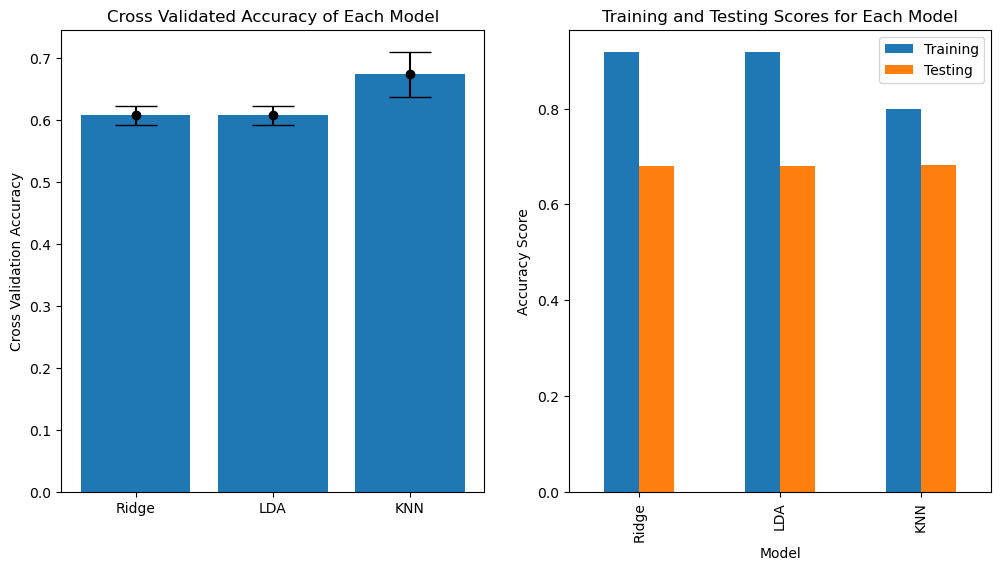

In [12]:
# Comparison of accuracy for each model
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
print(cv_scores)
axs[0].bar(["Ridge", "LDA", "KNN"], cv_scores)
axs[0].set_ylabel("Cross Validation Accuracy")
axs[0].set_title("Cross Validated Accuracy of Each Model")
#axs[0].set_ylim([0.8, 1])
axs[0].errorbar(["Ridge", "LDA", "KNN"], cv_scores, yerr=cv_stds,
               fmt = "o", color="k", capsize=15)

scores_df = {"Model": ["Ridge", "LDA", "KNN"], "Training": tr_scores,
         "Testing": te_scores}
scores_df = pd.DataFrame(scores_df)

scores_df.plot(x="Model", y=["Training", "Testing"], kind="bar", ax=axs[1])
axs[1].set_ylabel("Accuracy Score")
#axs[1].set_ylim([0.8, 1])
axs[1].set_title("Training and Testing Scores for Each Model")

# Neural Networks and Deep Learning

Text(0.5, 1.0, 'Hyperbolic Tangent')

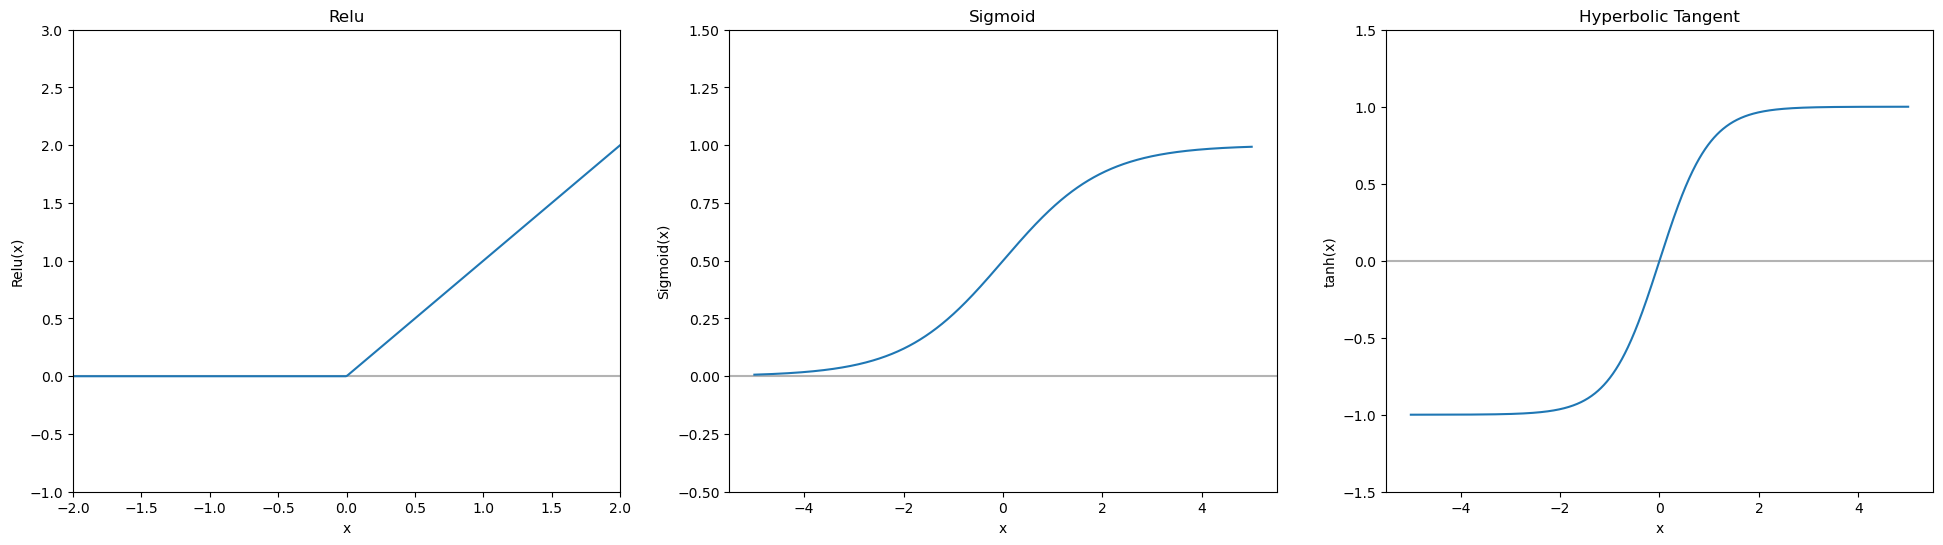

In [13]:
# Activation function plots
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return  1 / (1 + np.exp(-x))

fig, axs = plt.subplots(1, 3, figsize=(24,6))

for i in axs:
    i.axhline(y=0, color="0.7")

x = np.linspace(-5, 5, 1000)
axs[0].plot(x, relu(x))
axs[0].set_ylim(bottom=-1, top=3)
axs[0].set_xlim(left=-2, right=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Relu(x)')
axs[0].set_title('Relu')
axs[1].plot(x, sigmoid(x))
axs[1].set_ylim(bottom=-0.5, top=1.5)
axs[1].set_xlabel('x')
axs[1].set_ylabel('Sigmoid(x)')
axs[1].set_title('Sigmoid')
axs[2].plot(x, np.tanh(x))
axs[2].set_ylim(bottom=-1.5, top=1.5)
axs[2].set_xlabel('x')
axs[2].set_ylabel('tanh(x)')
axs[2].set_title('Hyperbolic Tangent')


In [14]:
# Generate training, validation, and testing data sets

x_train_raw, x_test_val, y_train_raw, y_test_val = train_test_split(all_images, all_labels, test_size=0.4)
x_val_raw, x_test_raw, y_val_raw, y_test_raw = train_test_split(x_test_val, y_test_val, test_size=0.5)

# Standardize

scaler = StandardScaler()
scale_x_train_raw = scaler.fit_transform(x_train_raw)
scale_x_val_raw = scaler.fit_transform(x_val_raw)
scale_x_test_raw = scaler.transform(x_test_raw)

# PCA

pcak95_nn = PCA(n_components=k95)
pcak95_nn.fit(scale_x_train_raw)
red_x_train_nn = pcak95_nn.components_ @ scale_x_train_raw.T
red_x_val_nn = pcak95_nn.components_ @ scale_x_val_raw.T
red_x_test_nn = pcak95_nn.components_ @ scale_x_test_raw.T

# To torch tensors

xtrain = torch.from_numpy(red_x_train_nn.astype(np.float32).T)
ytrain = torch.from_numpy(y_train_raw).long()
xval = torch.from_numpy(red_x_val_nn.astype(np.float32).T)
yval = torch.from_numpy(y_val_raw).long()
xtest = torch.from_numpy(red_x_test_nn.astype(np.float32).T)
ytest = torch.from_numpy(y_test_raw).long()


In [15]:
# Define Network

class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim, n_h_layers, hidden_dim, use_dropout, dropout_p, init, b_norm): 
        super(FCNN, self).__init__()
        #Define the network layer(s) and activation function(s)
        self.init = init
        self.bnorm = b_norm
        
        # Droput
        self.dropout_p = 0.5
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = torch.nn.Dropout(self.dropout_p)
        
        # Initial Layer
        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim, hidden_dim[0]))
        
        # Initialization
        if self.init=="Random Normal":
            torch.nn.init.normal_(self.layers[0].weight)
        elif self.init=="Xavier Normal":
            torch.nn.init.xavier_normal_(self.layers[0].weight)
        elif self.init=="Kaiming Uniform":
            torch.nn.init.kaiming_normal_(self.layers[0].weight)
        
        # Batch normalization
        if self.bnorm:
            self.layers.append(torch.nn.BatchNorm1d(hidden_dim[0]))
        
        # Hidden Layers
        for i in range(n_h_layers - 1):
            self.layers.append(torch.nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
            # Batch Normalization
            if self.bnorm:
                self.layers.append(torch.nn.BatchNorm1d(hidden_dim[i + 1]))
        
        # Output Layer
        self.layers.append(torch.nn.Linear(hidden_dim[-1], output_dim))
 
    def forward(self, input):
        #Define how your model propagates the input through the network
        for layer in self.layers[:-1]:
            if self.use_dropout:
                input = self.dropout(torch.nn.functional.relu(layer(input)))
            else:
                input = torch.nn.functional.relu(layer(input))
        return self.layers[-1](input)

In [16]:
# Model Training and Validation Function

def run_model(use_dropout, initialization, using_batch_norm, learning_rate, opti):
    # Initialize neural network model with input, output and hidden layer dimensions
    num_hidden_layers = 3
    hidden_dim_array = [400, 200, 200]

    dropout_p = 0.5

    model = FCNN(input_dim=k95, output_dim=2, n_h_layers=num_hidden_layers, hidden_dim=hidden_dim_array, use_dropout=use_dropout, dropout_p=dropout_p, init=initialization, b_norm=using_batch_norm) #... add more parameters

    # Define the learning rate and epochs number
    epochs = 100

    train_loss_list = np.zeros((epochs,))
    validation_accuracy_list = np.zeros((epochs,))
    validation_loss_list = np.zeros((epochs,))

    # Define loss function  and optimizer
    loss_func = torch.nn.CrossEntropyLoss()# Use Cross Entropy loss from torch.nn 
    if opti == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif opti == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif opti == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# Use optimizers from torch.optim

    for epoch in tqdm.trange(epochs):

        model.train()
        optimizer.zero_grad()
        train_outputs = model(xtrain)
        loss = loss_func(train_outputs, ytrain)
        loss.backward()
        optimizer.step()
        train_loss_list[epoch] = loss.item()

        with torch.no_grad():
            model.eval()
            val_outputs = model(xval)
            val_loss = loss_func(val_outputs, yval).item()
            validation_loss_list[epoch] = val_loss
            correct = (torch.argmax(val_outputs, dim=1) == yval).type(torch.FloatTensor).mean()
            validation_accuracy_list[epoch] = correct
    
    with torch.no_grad():
        model.eval()
        y_pred_test = model(xtest)
        correct = (torch.argmax(y_pred_test, dim=1) == ytest).type(torch.FloatTensor).mean()
    
    return train_loss_list, validation_accuracy_list, validation_loss_list, correct.item()

In [42]:
# Define Parameters and Run Model

use_dropout = False
initializations = ["Random Normal", "Xavier Normal", "Kaiming Uniform", "None"]
initialization = initializations[-1]
using_batch_norm = False
learning_rate = 0.0001
optimizers = ["SGD", "RMSprop", "Adam"]
optimizer = optimizers[2]

tll, val, vll, test_acc = run_model(use_dropout, initialization, using_batch_norm, learning_rate, optimizer)

100%|██████████| 100/100 [00:02<00:00, 40.82it/s]


In [43]:
print("Testing Accuracy: " + str(np.round(test_acc * 100, 3)))

Testing Accuracy: 70.312


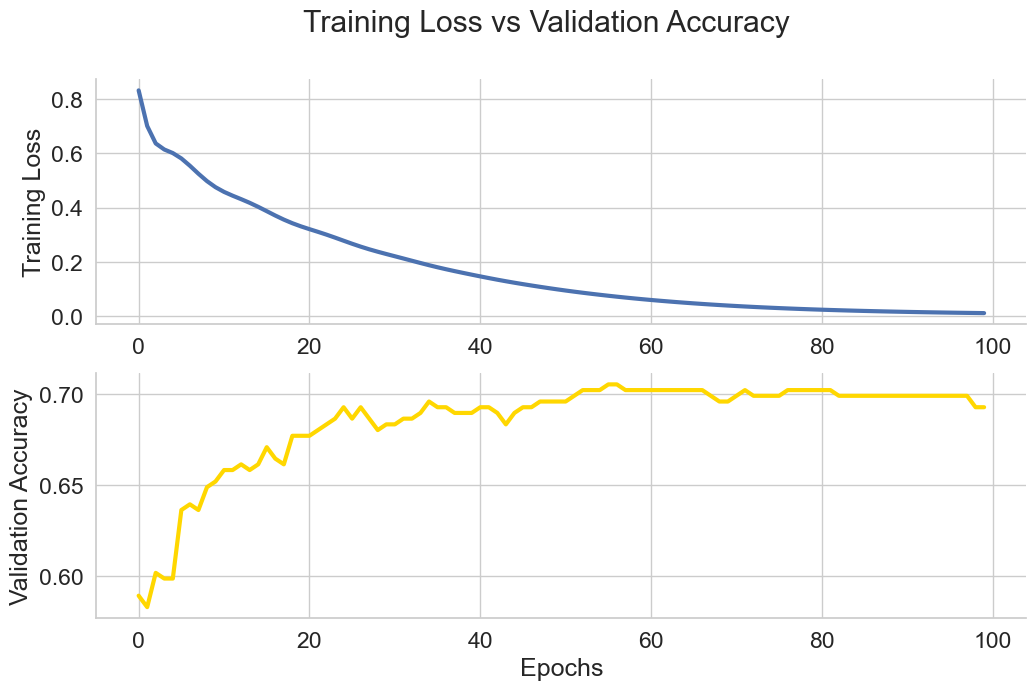

In [44]:
# Plot training loss and validation accuracy throughout the training epochs

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1.5)

plt.figure(figsize = (12, 7))
plt.suptitle("Training Loss vs Validation Accuracy")
plt.subplot(2, 1, 1)
plt.plot(tll, linewidth = 3)
plt.ylabel("Training Loss")
plt.subplot(2, 1, 2)
plt.plot(val, linewidth = 3, color = 'gold')
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
sns.despine()


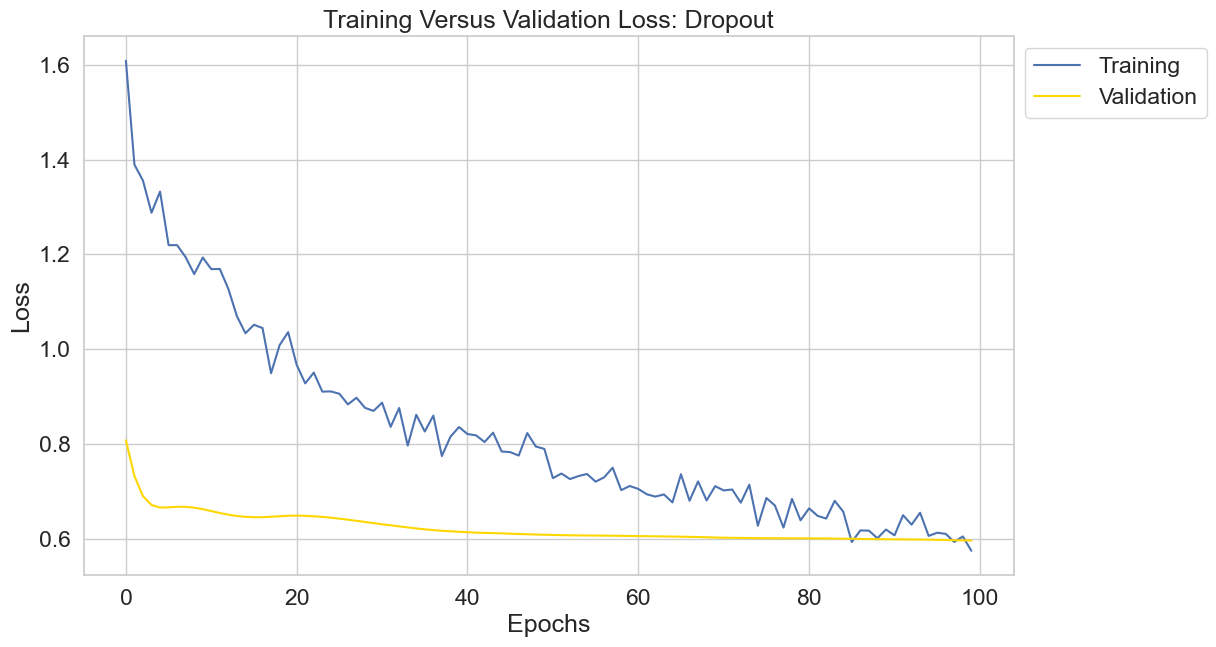

In [41]:
# Plot the training and validation loss curves
plt.figure(figsize = (12, 7))
plt.plot(tll)
plt.plot(vll, color='gold')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(labels=["Training", "Validation"], loc='upper left', bbox_to_anchor=(1,1))
plt.title("Training Versus Validation Loss: Dropout")
plt.show()

In [22]:
# Test Optimizers and Learning Rates

lrs = [0.1, 0.01, 0.001, 0.0001]
n = 5
res_dic = {}
for o in optimizers:
    for l in lrs:
        key = o + " " + str(l)
        res = []
        for i in range(n):
            tll, val, vll, test_acc = run_model(use_dropout, initialization, using_batch_norm, l, o)
            res.append(test_acc)
        res = np.array(res)
        res_dic[key] = [np.mean(res), np.std(res)]

100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


[11  1  6 10  7  2  5  9  4  3  8  0]


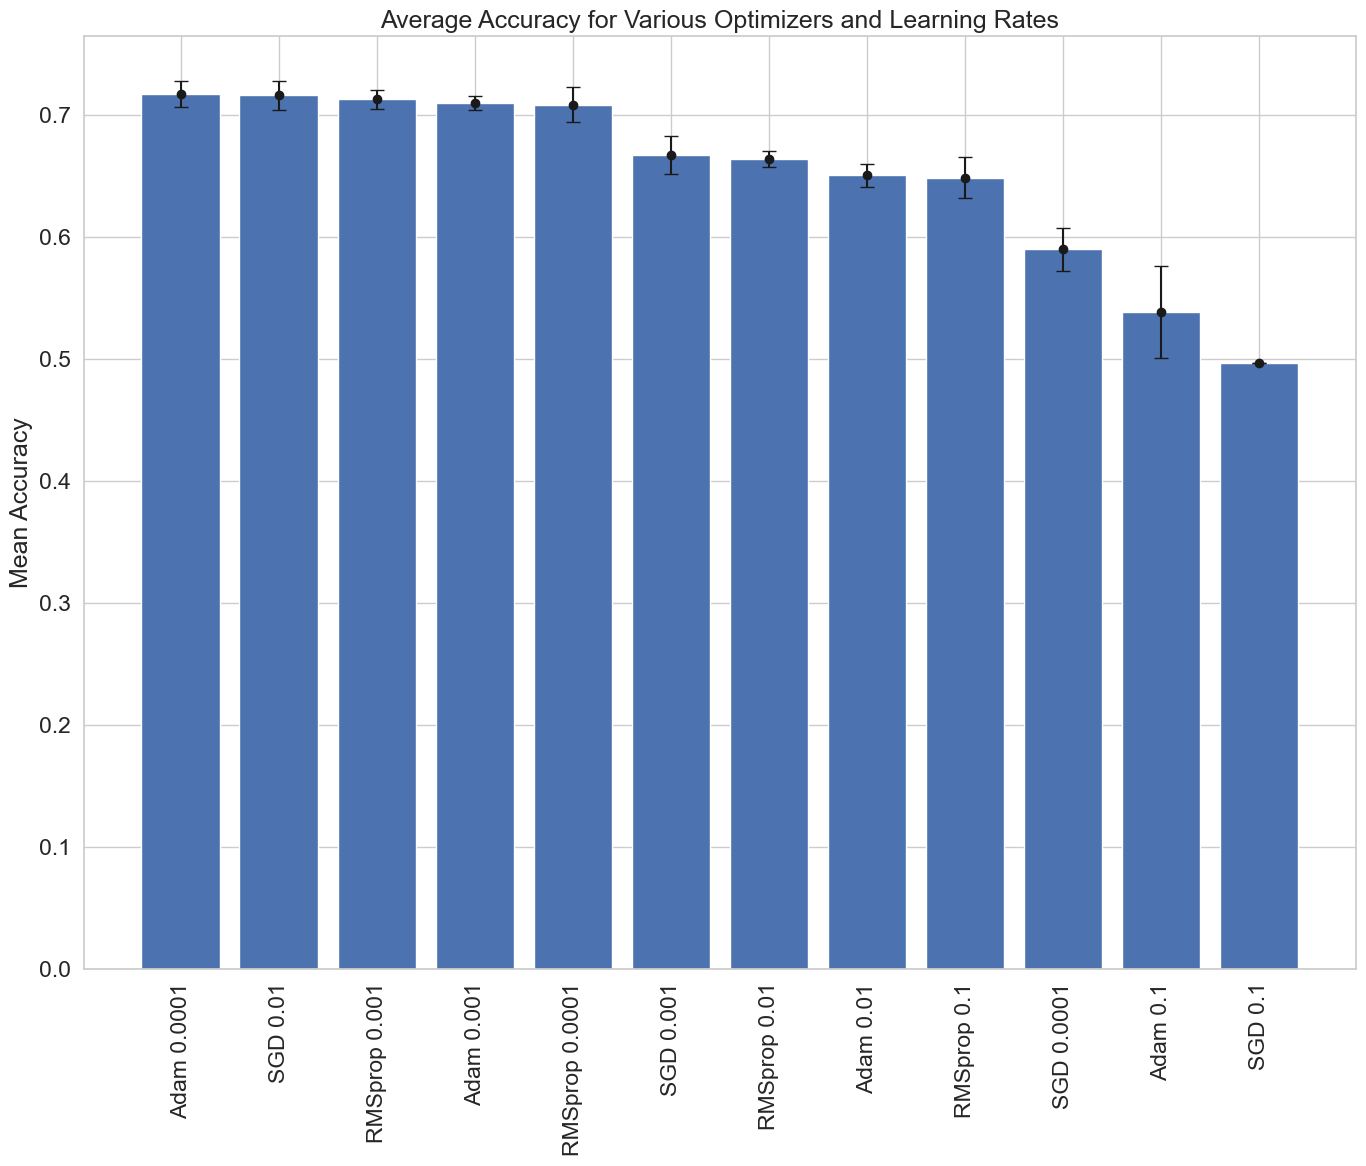

In [23]:
# Plot optimizer and learning rate test results

o_means = []
o_stds = []
for key in list(res_dic.keys()):
    o_means.append(res_dic[key][0])
    o_stds.append(res_dic[key][1])
o_means = np.array(o_means)
o_stds = np.array(o_stds)
sort_ids = np.argsort(o_means)[::-1]
print(sort_ids)
sort_means = o_means[sort_ids]
sort_stds = o_stds[sort_ids]

plt.figure(figsize=(14, 12))
plt.bar(np.array(list(res_dic.keys()))[sort_ids], sort_means)
plt.errorbar(np.array(list(res_dic.keys()))[sort_ids], sort_means, yerr=sort_stds,
               fmt = "o", color="k", capsize=5)
plt.ylabel("Mean Accuracy")
plt.title("Average Accuracy for Various Optimizers and Learning Rates")
plt.xticks(rotation='vertical')
plt.tight_layout()

In [24]:
# Test Dropout

n = 5
opts = [True, False]
db_means = []
db_stds = []
for o in opts:
    res = []
    for i in range(n):
        tll, val, vll, test_acc = run_model(o, initialization, using_batch_norm, 0.001, "Adam")
        res.append(test_acc)
    res = np.array(res)
    db_means.append(np.mean(res))
    db_stds.append(np.std(res))
        
# Test Batchnorm 

for o in opts:
    res = []
    for i in range(n):
        tll, val, vll, test_acc = run_model(use_dropout, initialization, o, 0.001, "Adam")
        res.append(test_acc)
    res = np.array(res)
    db_means.append(np.mean(res))
    db_stds.append(np.std(res))

100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


Text(0, 0.5, 'Mean Accuracy')

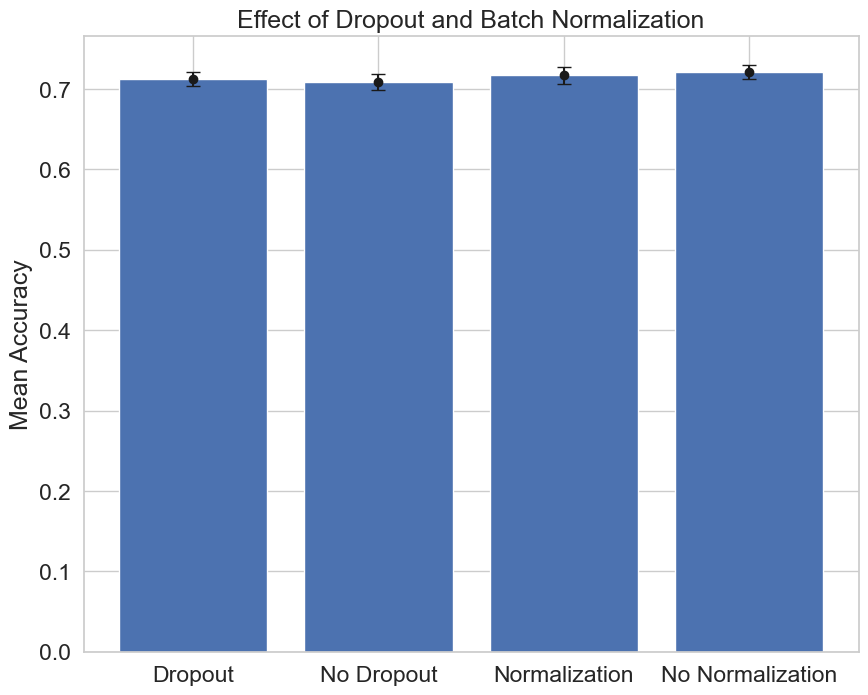

In [25]:
# Plot dropout and batchnorm results
plt.figure(figsize=(10, 8))
plt.bar(["Dropout", "No Dropout", "Normalization", "No Normalization"], db_means)
plt.errorbar(["Dropout", "No Dropout", "Normalization", "No Normalization"], db_means, yerr=db_stds, fmt = "o", color="k", capsize=5)
plt.title("Effect of Dropout and Batch Normalization")
plt.ylabel("Mean Accuracy")

In [26]:
# Test intitialiazations
in_means = []
in_stds = []
for inits in initializations:
    res = []
    for i in range(n):
        tll, val, vll, test_acc = run_model(use_dropout, inits, using_batch_norm, 0.001, "Adam")
        res.append(test_acc)
    res = np.array(res)
    in_means.append(np.mean(res))
    in_stds.append(np.std(res))

100%|██████████| 100/100 [00:02<00:00, 37.62it/s]


Text(0.5, 1.0, 'Effect of Initializations on Accuracy')

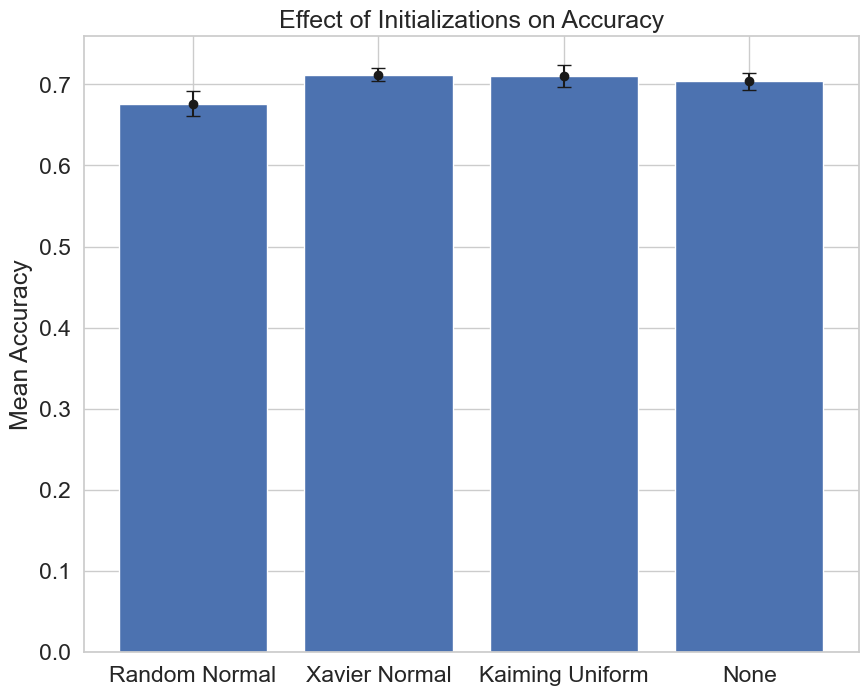

In [28]:
# Plot initialization test results
plt.figure(figsize=(10, 8))
plt.bar(initializations, in_means)
plt.errorbar(initializations, in_means, yerr=in_stds, fmt = "o", color="k", capsize=5)
plt.ylabel("Mean Accuracy")
plt.title("Effect of Initializations on Accuracy")

(-0.5, 299.5, 299.5, -0.5)

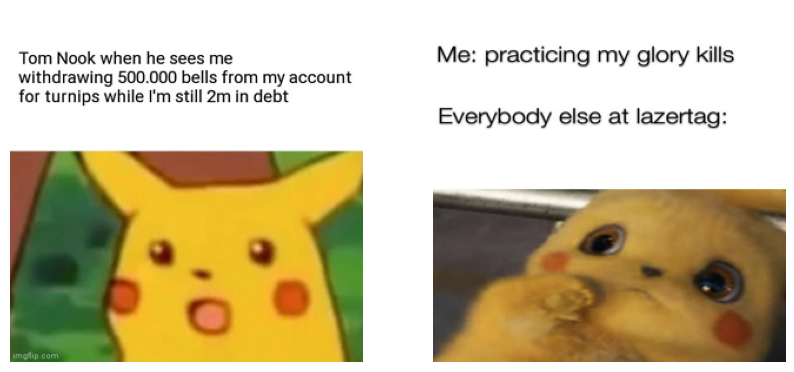

In [118]:
# Plot comparison of two similar images
a_ind = 250
d_ind = 214
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ac_images[a_ind].reshape((300, 300, 3)))
axs[0].axis("off")
axs[1].imshow(dm_images[d_ind].reshape((300, 300, 3)))
axs[1].axis("off")